# Round 5. Pagerank

PageRank, a generalization of eigenvector centrality for directed networks, is used by *e.g.* Google to determine the centrality of web pages. If we consider a random walker that with probability $d$ moves to one of the successors of the current node (i.e. nodes linked **to** by the current node) and with probability $1 - d$ teleports to a random node, PageRank of each node equals the fraction of time the random walker spent in that node. 

In this exercise, we investigate the behavior of PageRank in a simple directed model network (see fig below). To get started, you can use this notebook for reference. The usage of the notebook or template is **optional**. Then you only need to fill in the required functions. Some of the functions do NOT need modifications. You may start your solution after the subtitle "**Begin of the Exercise**" down below. 

In addition to returning a short report of your results (including the visualizations), return also your commented Python code or notebook. Remember to label the axes in your figures!


In [1]:
from IPython.display import Image
import timeit
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import networkx as nx
from pprint import pprint

In [2]:
def add_colorbar(cvalues, cmap='OrRd', cb_ax=None):
    """
    Add a colorbar to the axes.

    Parameters
    ----------
    cvalues : 1D array of floats

    """
    eps = np.maximum(0.0000000001, np.min(cvalues)/1000.)
    vmin = np.min(cvalues) - eps
    vmax = np.max(cvalues)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scm = mpl.cm.ScalarMappable(norm, cmap)
    scm.set_array(cvalues)
    if cb_ax is None:
        plt.colorbar(scm)
    else:
        cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='vertical')

## Data
Let us load the data from the right folder and assign the names for all the plots we will save. If you run this notebook in your machine, please specify the right folder.

In [3]:
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = ''

print('The data directory is %s' % course_data_dir)

network_path = os.path.join(course_data_dir, 'pagerank_network.edg')

The data directory is /coursedata


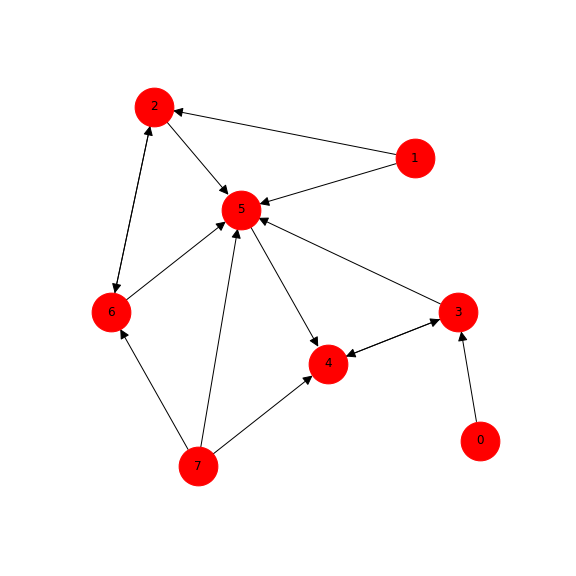

In [4]:
fig = Image(filename=(os.path.join(course_data_dir, 'pagerank_network.png')))
fig

# Begin of the exercise
Write your code here to compute the pagerank

### a. Network visualization
Load the network given in file `pagerank_network.edg` and, as a sanity check, visualize it with `nx.draw`. You would need to modify the function `visualize_network` for this purpose.

**Hint**:
To load the directed network, use parameter `create_using=nx.DiGraph()` when reading the edge list.
NetworkX visualization of directed graphs is somewhat ugly but sufficient for the present purposes. In fact, the spring layout algorithm in NetworkX, which is its default algorithm for computing node positions, works only well with undirected graphs, so for computing the layout, it's better to feed the algorithm the undirected version of the network. In addition, the algorithm can give different results on different runs, so it may be useful to plot the network a few times until the result looks good.

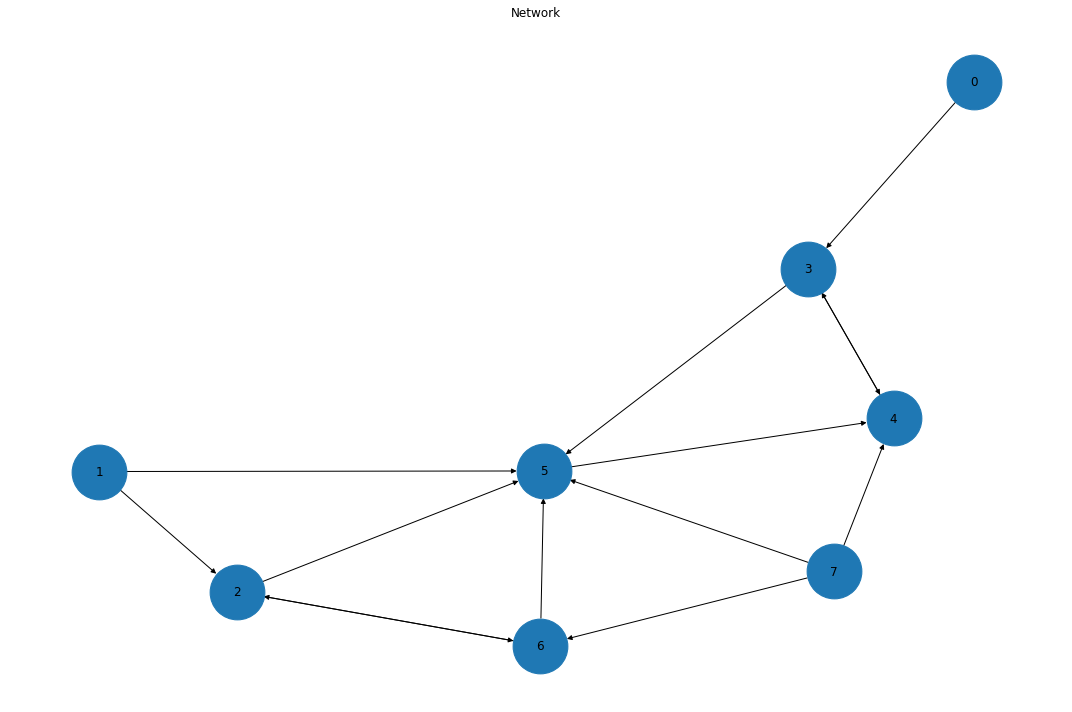

In [5]:
def visualize_network(network, node_positions, cmap='OrRd',
                      node_size=3000, node_colors=[], with_labels=True, title=""):
    """
    Visualizes the given network using networkx.draw and saves it to the given
    path.

    Parameters
    ----------
    network : a networkx graph object
    node_positions : a dict of positions of nodes, obtained by e.g. networkx.spring_layout
        e.g. {'0': array([-1.        ,  0.67443041]), '3': array([-0.50915908,  0.2993651 ])
    cmap : colormap
    node_size : int
    node_colors : a list of node colors
    with_labels : should node labels be drawn or not, boolean
    title: title of the figure, string
    """

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    if node_colors:
        # Write code to visualize the networks with nodes colored by PageRank.
        # use nx.draw and make use of parameters pos, node_color,
        # cmap, node_size and with_labels
        nx.draw(network, pos=node_positions, node_color=node_colors, cmap=cmap, node_size=node_size, with_labels=with_labels)
        add_colorbar(node_colors)
    else:
        # Write code to visualize the networks without node coloring.
        # use nx.draw and make use of parameters pos, cmap, node_size and
        # with_labels
        nx.draw(network, pos=node_positions, cmap=cmap, node_size=node_size, with_labels=with_labels)
    ax.set_title(title)
    plt.tight_layout()

    return fig

net =  nx.read_edgelist(network_path, create_using=nx.DiGraph())
# Variable for the last cell
base_net = net
# Visualization of the network (note that spring_layout is intended to be used with undirected networks):
node_positions = nx.spring_layout(net.to_undirected())
cmap = 'OrRd'
node_size = 3000

fig=visualize_network(net, node_positions, cmap=cmap, node_size=node_size, title="Network")

fig.savefig('./network_visualization.pdf')

### b. Compute the pagerank

Write a function that computes the PageRank on a network by simulating a random walker. In more detail:
1. Initialize the PageRank of all nodes to 0.
2. Pick the current node (the starting point of the random walker) at random.
3. Increase the PageRank of the current node with 1.
4. Select the node, to which the random walker will move next:
    - Draw a random number $p \in [0, 1]$.
    - If $p < d$, the next node is one of the successors of the current one. Pick it randomly.
    - Else, the random walker will teleport. Pick the next node randomly from all the network nodes.
5. Repeat steps 3-4 $N_{steps}$ times.
6. Normalize the PageRank values by $N_{steps}$.

Use your function to compute PageRank in the example network.
Visualize the result on the network: update your visualization from a) by using the PageRank values as node color values.  Compare your results with `nx.pagerank` by plotting both results as a function of node index. Note that the above algorithm is only a naive way of computing PageRank. The actual algorithm behind the success of Google, introduced by its founders, Larry Page and Sergey Brin, is based on power iteration (Brin, S and Page, L, 2012, Reprint of: The anatomy of a large-scale hypertextual web search engine).

**Hint**:
The damping factor is normally set to $d = 0.85$. $N_{steps} = 10 000$ is a reasonable choice.


In [6]:
import random

def pageRank(network, d, n_steps):
    """
    Returns the PageRank value, calculated using a random walker, of each
    node in the network. The random walker teleports to a random node with
    probability 1-d and with probability d picks one of the neighbors of the
    current node.

    Parameters
    -----------
    network : a networkx graph object
    d : damping factor of the simulation
    n_steps : number of steps of the random walker

    Returns
    --------
    page_rank: dictionary of node PageRank values (fraction of time spent in
               each node)
    """

    # Initializing PageRank dictionary:
    nodes = list(network.nodes())

    # Write code for calculating PageRank of each node
    # Use the random walker algorithm.
    # Some pseudocode:

    # 1) Initialize PageRank of each node to 0
    # 2) Pick a random starting point for the random walker (Hint: np.random.choice)
    # 3) Random walker steps, at each step:
    #   1) Increase the PageRank of current node by 1
    #   2) Check if the random walker will teleport or go to a neighbor
    #   3) Pick the next node either randomly or from the neighbors
    #   4) Update the current node variable to point to the next node
    # 4) Repeat random walker steps 1-4 n_steps times
    # 5) Normalize PageRank by n_steps
    
    # e.g. {'0': 0, '3': 0}
    PageRank = {i:0 for i in network.nodes}
    node = random.choice(list(PageRank))
    PageRank[node] += 1
    for i in range(n_steps):
        # Pick one of the next nodes
        neighbors = list(network.successors(node))
        
        # If:
        # - p < 0.85, or
        # - there is no neighbor
        if random.random() > d or not neighbors:
            node = random.choice(nodes)
        else:
            # Pick random node
            node = random.choice(neighbors)
        PageRank[node] += 1
        
    sum_PageRank = sum(PageRank.values())

    # Normalize values to 1
    for idx, val in PageRank.items():
        PageRank[idx] = val/sum_PageRank
    
    return PageRank


nodes = net.nodes()
n_nodes = len(nodes)

n_steps = 10000#4*n_nodes
d = 0.85

pageRank_rw = pageRank(net, d, n_steps)
# pageRank_rw

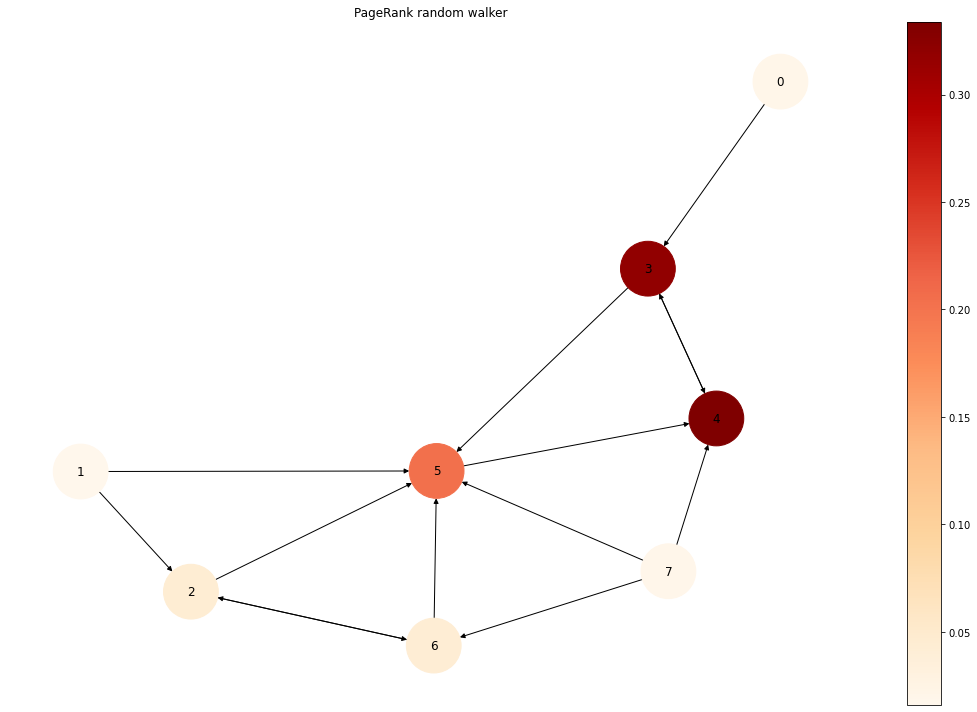

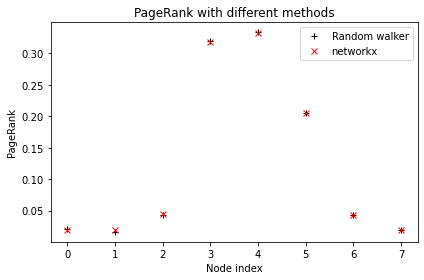

In [7]:
# Visualization of PageRank on network:
node_colors = [pageRank_rw[node] for node in nodes]

fig = visualize_network(net, node_positions, cmap=cmap, node_size=node_size,
                        node_colors=node_colors, title="PageRank random walker")
# fig.savefig('./network_visualization_pagerank_rw.pdf')

# PageRank with networkx:
pageRank_nx = nx.pagerank(net)

# Visualization to check that results from own function and nx.pagerank match:

pageRank_rw_array = np.zeros(n_nodes)
pageRank_nx_array = np.zeros(n_nodes)
for node in nodes:
    pageRank_rw_array[int(node)] = pageRank_rw[node]
    pageRank_nx_array[int(node)] = pageRank_nx[node]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(0, n_nodes), pageRank_rw_array, 'k+', label=r'Random walker')
plt.plot(range(0, n_nodes), pageRank_nx_array, 'rx', label='networkx')
ax.set_xlabel(r'Node index')
ax.set_ylabel(r'PageRank')
ax.set_title(r'PageRank with different methods')
ax.legend(loc=0)
plt.tight_layout()

fig.savefig('./network_visualization_pagerank_nx.pdf')

### c. Pagerank based on power iteration

The above algorithm is a naive way of computing PageRank. The actual algorithm behind the success of Google, introduced by its founders, Larry Page and Sergey Brin, is based on power iteration (Brin, S and Page, L, 2012).

The power iteration can be shown to find the leading eigenvector for the "Google matrix" (or other matrices) very fast under certain conditions. An intuitive way of thinking about the power iteration algorithm is to think that at time $t-1$ you have a vector $x(t-1)$ where each element gives the probability of finding the walker. You use the rules of the random walk/teleportation process to find out what are the probabilities of finding the random walkers at each node at time $t$. That is you increase the time $t$ and calculate $x(t)$ based on $x(t-1)$ until the vector $x$ doesn't change any more. 

Your task is to write a function that computes the PageRank by using power iteration. In more detail:

1. Initialize the PageRank of all nodes to $\frac{1}{n}$, where $n$ is the number of nodes in the network. That is, at the iteration $t=0$ your PageRank vector contains the same value for each node, and it is equally likely to find the walker in each node. (Any other initialization strategy is possible as long as the sum of all elements is one, and the closer the initial vector is to the final vector the faster you will find the final PageRank values.)
2. Increase the iteration number $t$ by one and create a new empty PageRank vector $x(t)$.
3. Fill in each element of the new vector PageRank vector $x(t)$ using the old PageRank vector $x(t-1)$ and the formula: $x_i(t)=(1-d)\frac{1}{n}+d\sum_{j \in \nu_i}\frac{x_j(t-1)}{k_j^{\mathrm{out}}}$, where $\nu_i$ is the set of nodes that have a directed link ending at $i$, and for each such node $j \in \nu_i$, $k_j^{\mathrm{out}}$ is $j$'s out-degree. In summary, for each node $i$ you need to calculate their entry in the new PageRank vector $x(t)$ as a sum of two parts:
    - probability that the walker will teleport into the node $(1-d)\frac{1}{n}$ and
    - probability that the walker will move from a neighbor $j$ to node $i$. Iterate over each in-neighbor $j$ of the node $i$ (i.e., there is a link from $i$ to $j$) and add the neighbors contribution $d\frac{x_j(t-1)}{k_j^{\mathrm{out}}}$ to the entry of the node $i$ in the new PageRank vector $x(t)$.
4. Repeat steps 2 and 3 $N_{\mathrm{iterations}}$ times.

Use your function to compute PageRank} in the example network and
Visualize the result on the network as in b).

**Hints**:
- The damping factor is normally set to $d = 0.85$. 
- You can monitor the progress of the power iteration by printing out the change in the PageRank vector $\Delta(t)=\sum_i | x_{i}(t) - x_{i}(t-1)|$ after each iteration step. The change $\Delta(t)$ should be decreasing function of $t$. $N_{\mathrm{iterations}} = 10$ should be more than enough in most cases.
- You can list the incoming edges to node $i$ with the function `net.in_edges(i)`, where `net` is the network object. Alternatively, you can use the function `net.predecessors(i)`, which returns an iterator over predecessors nodes of node $i$. 
- The sum of all elements in the PageRank vector should always equal to one. There might be slight deviations from this due to numerical errors, but much larger or smaller values is an indication that something is wrong with the code.

In [8]:
def pagerank_poweriter(g, d, iterations):
    """
    Uses the power iteration method to calculate PageRank value for each node
    in the network.

    Parameters
    -----------
    g : a networkx graph object
    d : damping factor of the simulation
    iterations : number of iterations to perform

    Returns
    --------
    pr_old : dict where keys are nodes and values are PageRank values
    """
    print("Running function for obtaining PageRank by power iteration...")
    
    # Some pseudocode:
    # 1) Create a PageRank dictionary and initialize the PageRank of each node
    #    to 1/n where n is the number of nodes.
    # 2) For each node i, find nodes having directed link to i and calculate
    #    sum(x_j(t-1)/k_j^out) where the sum is across the node's neighbors
    #    and x_j(t-1) is the PageRank of node  .
    # 3) Update each node's PageRank to (1-d)*1/n + d*sum(x_j(t-1)/k_j^out).
    # 4) Repeat 2-3 n_iterations times.
    
    # Optional code for sanity checks (note that these need to be printed out after each iteration):

    n = net.number_of_nodes()
    # {'0': 0.125, '3': 0.125, ...}
    pr_old = {i:1/n for i in net.nodes}
    # for t timesteps
    for i in range(iterations):
        # Initialize with an impossible values for sanity check
        pr_new = {i:-1000 for i in net.nodes}
        for node_i in pr_old:
            summation = 0
            # Nodes having directed link to i, e.g. [('0', '3'), ('4', '3'), ('1', '3')]
            in_edges = net.in_edges(node_i)
            for node_j, _ in in_edges:
                x_j = pr_old[node_j]
                k_j = len(net.out_edges(node_j))
                summation += x_j/k_j
            pr_new[node_i] = ((1-d)*(1/n))+(d*summation)
#         print("SUM", sum(pr_new.values()))
        # Sanity check
        assert -1000 not in pr_new.values()
#         print(f'Iter {i} - PageRank difference since last iteration:', sum([abs(pr_new[i]-pr_old[i]) for i in g]))
        pr_old = pr_new
    return pr_old

# PageRank with power iteration
n_iterations = 10
pageRank_pi = pagerank_poweriter(base_net, d, n_iterations)
pageRank_pi

Running function for obtaining PageRank by power iteration...


{'0': 0.018750000000000003,
 '3': 0.31682517081512873,
 '1': 0.018750000000000003,
 '2': 0.04511860824883039,
 '5': 0.2048394021494937,
 '6': 0.04326174075481354,
 '4': 0.3337050780317334,
 '7': 0.018750000000000003}

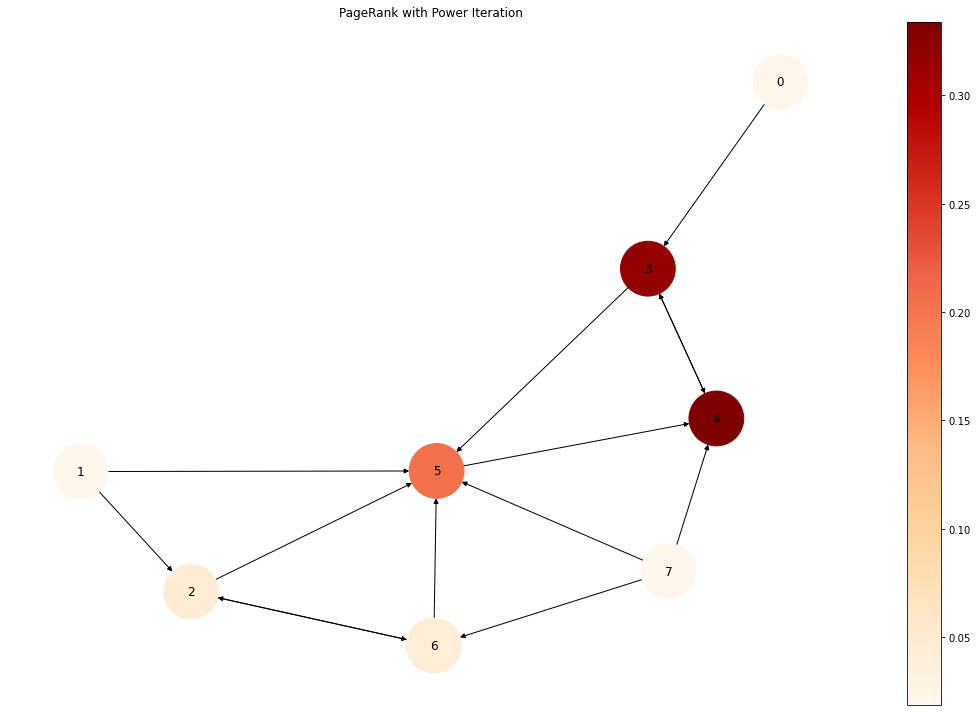

In [9]:
nodes = base_net.nodes()
nodes

# Visualization of PageRank on network:
node_colors = [pageRank_pi[node] for node in nodes]

fig = visualize_network(base_net, node_positions,
                        cmap=cmap, node_size=node_size,
                        node_colors=node_colors, title="PageRank with Power Iteration")

In [10]:

# PageRank with networkx:
pageRank_nx = nx.pagerank(base_net)

# Visualization to check that results from own function and nx.pagerank match:

pageRank_rw_array = np.zeros(n_nodes)
pageRank_nx_array = np.zeros(n_nodes)
pageRank_pi_array = np.zeros(n_nodes)
for node in nodes:
    pageRank_rw_array[int(node)] = pageRank_rw[node]
    pageRank_nx_array[int(node)] = pageRank_nx[node]
    pageRank_pi_array[int(node)] = pageRank_pi[node]

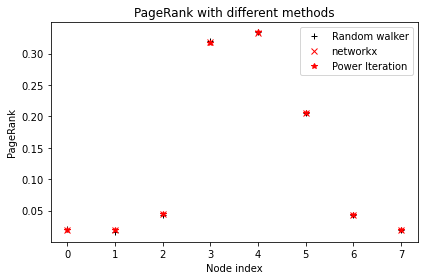

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(0, n_nodes), pageRank_rw_array, 'k+', label=r'Random walker')
plt.plot(range(0, n_nodes), pageRank_nx_array, 'rx', label='networkx')
plt.plot(range(0, n_nodes), pageRank_pi_array, 'r*', label='Power Iteration')
ax.set_xlabel(r'Node index')
ax.set_ylabel(r'PageRank')
ax.set_title(r'PageRank with different methods')
ax.legend(loc=0)
plt.tight_layout()

# fig.savefig('./network_visualization_pagerank_nx.pdf')

### d. Time estimations
The Google search engine indexes billions of websites and the algorithm for calculating the PageRank needs to be extremely fast. In the original paper about PageRank (Brin, S and Page, L, 2012), by Google founders Larry Page and Sergey Brin, they claim that their "iterative algorithm" is able to calculate the PageRank for 26 million webpages in a few hours using a normal desktop computer (in 1998). 

Come up with a rough estimate of how long it would take for your power iteration algorithm (part c) and naive random walker algorithm (part b) to do the same. You can assume that the average degree of the 26 million node network is small and that the power iteration converges in the same number of steps as it does for your smaller networks. For the random walk you can assume that you need to run enough steps that the walker visits each node on average $1000$ times. You can also omit any considerations of fitting the large network in memory or the time it takes to read it from the disk etc. With these assumption you can simply calculate the time it takes to run the algorithm in a reasonable size network and multiply the result by the factor that the 26 million node network is bigger than your reasonable sized network.

Report all calculations and parameters you use (such as size of the network, number of steps); simply reporting the result without telling how you obtained it will not get you any points. 


**Hints**:
- There are several ways of timing your code. You can use for example IPython's ``%timeit`` command or the Python ``timeit`` module.
- The small example network is probably going to be too small to test out the speed of your function especially if you measure the time it takes to run a Python script. (In this case your function might take milliseconds to run but running the whole script might still take a second or so because of starting Python and loading various modules.) You should aim for a network for which it takes several seconds to run the PageRank function. You might find it useful to use network model in networkx to run your code. For example, ``net=nx.directed_configuration_model(10**4*[5],10**4*[5],create_using=nx.DiGraph())`` will produce network with 10000 nodes where each node has in and out degrees of 5 using the configuration model.
- Don't feel bad if you cannot beat Larry and Sergey in speed when using Networkx and Python. These tools are not meant for speed of computation and even modern computers might not be enough to help. Also, your competition invented Google.

In [12]:
# Investigating the running time of the power iteration fuction
num_tests = 3

# k5net = nx.DiGraph() # Replace with a test network of suitable size
# Print results: how many seconds were taken for the test network of
# 10**4 nodes, how many hours would a 26*10**6 nodes network take? 
# Run num_tests times and use the average or minimum running time in your calculations.

# Investigating the running time of the random walker function
n_nodes = 10**4

# Each node gets visited on average 1000 times
# Undestand if it's correct
n_steps = 1000

net=nx.directed_configuration_model(n_nodes*[5],n_nodes*[5],create_using=nx.DiGraph())

In [13]:
%timeit -r 3 pagerank_poweriter(net, d, 10)
"Done"

Running function for obtaining PageRank by power iteration...
Running function for obtaining PageRank by power iteration...
Running function for obtaining PageRank by power iteration...
Running function for obtaining PageRank by power iteration...
2.11 s ± 23.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


'Done'

In [14]:
%timeit -r 3 pageRank(net, d, 1000*n_nodes)
"Done"

10.7 s ± 50.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


'Done'

### e. What does it mean?
The aim of this task is to understand how the structure of a network relates to PageRank. Remember to justify your answers.  


1. What is the connection between a node's in-degree $k_{in}$ and its PageRank (if any)? If you know only the in-degrees of two nodes (in the same network), can you tell which one has a higher PageRank? (1 p)

2. What is the connection between a node's out-degree $k_{out}$ and its PageRank (if any)? (0.5 p)

3. How does PageRank change if the node belongs to a strongly connected component? (0.5 p)

4. How could the information about the network's structure be used in improving the power iteration algorithm given in part c)? (0.5 p) <br> **Hint**: Are there ways to incorporate this information to make the algorithm converge faster?

5. Explain why the PageRanks of nodes 3 and 4 in the plotted network are higher than that of node 5. (0.5 p)


### f. The damping factor
Investigate the effect of the damping factor $d$ on the PageRank values of the network used in parts a)-c). Repeat the PageRank calculation with *e.g.* 5 different values of $d \in [0,1]$ and plot the PageRank as a function of node index (plots of all values of  $d$ in the same figure). Interpret the results. How and why does the change of $d$ affect the rank of the nodes and the absolute PageRank values? Explain what happens, when d=0 and when d=1. 

In case you do not trust your implementations in b) and c), you can use PageRank values obtained with `nx.pagerank` in this last task. 

[0.12508749 0.12918708 0.12868713 0.12378762 0.12128787 0.12818718
 0.12088791 0.12288771]
[0.10158984 0.09989001 0.12738726 0.14478552 0.15158484 0.15258474
 0.12148785 0.10068993]
[0.07479252 0.07509249 0.11118888 0.18088191 0.19678032 0.18058194
 0.10258974 0.07809219]
[0.04619538 0.04749525 0.09249075 0.22377762 0.24857514 0.20037996
 0.08919108 0.05189481]
[0.02629737 0.02379762 0.05749425 0.2989701  0.31866813 0.19988001
 0.04969503 0.02519748]
[0.         0.         0.         0.40125987 0.40115988 0.19758024
 0.         0.        ]


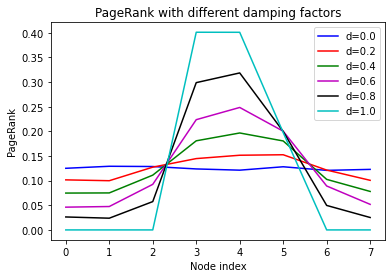

In [15]:
def investigate_d(network, ds, colors, n_steps):
    """
    Calculates PageRank at different values of the damping factor d and
    visualizes and saves results for interpretation

    Parameters
    ----------
    network : a NetworkX graph object
    ds : a list of d values
    colors : visualization color for PageRank at each d, must have same length as ds
    n_steps : int; number of steps taken in random walker algorithm
    """
    n_nodes = len(network.nodes())
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Write a for loop to obtain node PageRank values at each d and to plot the PageRank.
    # use zip to loop over ds and colors at once
    n_nodes = network.number_of_nodes()
    for d, color in zip(ds, colors):
        page_rank = pageRank(network, d, n_steps)
        page_rank_array = np.zeros(n_nodes)
        for node in network.nodes():
            page_rank_array[int(node)] = page_rank[node]
        print(page_rank_array)
        plt.plot(range(0, n_nodes), page_rank_array, color=color, label=f"d={d}")
        
    ax.set_xlabel(r'Node index')
    ax.set_ylabel(r'PageRank')
    ax.set_title(r'PageRank with different damping factors')
    ax.legend(loc=0)
    plt.tight_layout
    return fig

# Investigating effects of d:
ds = np.arange(0, 1.2, 0.2)
ds = np.around(ds,1)
colors = ['b', 'r', 'g', 'm', 'k', 'c']
# TODO: check number of steps, probably it's not 10.000
investigate_d(base_net, ds, colors, 10000)
plt.legend()
plt.show()